In [3]:
import re
import numpy as np
import pandas as pd
import csv
import contractions
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string

In [4]:
# Loading the dataset
with open("D:\DSL\development.csv" , encoding='utf8') as f:
  reader = list(csv.reader(f))
  col_name= reader.pop(0)
df = pd.DataFrame(reader, columns=col_name)

In [5]:
# Checking for Null values
null_count = np.sum(df.isnull().any(axis=1))
null_count

0

<AxesSubplot:xlabel='sentiment', ylabel='count'>

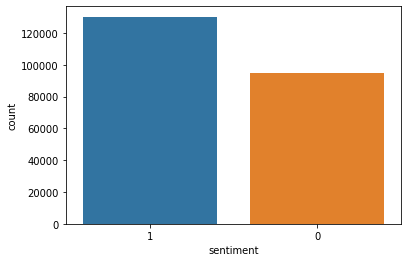

In [6]:
# Ploting sentiment distribution
sns.countplot(x='sentiment', data=df)

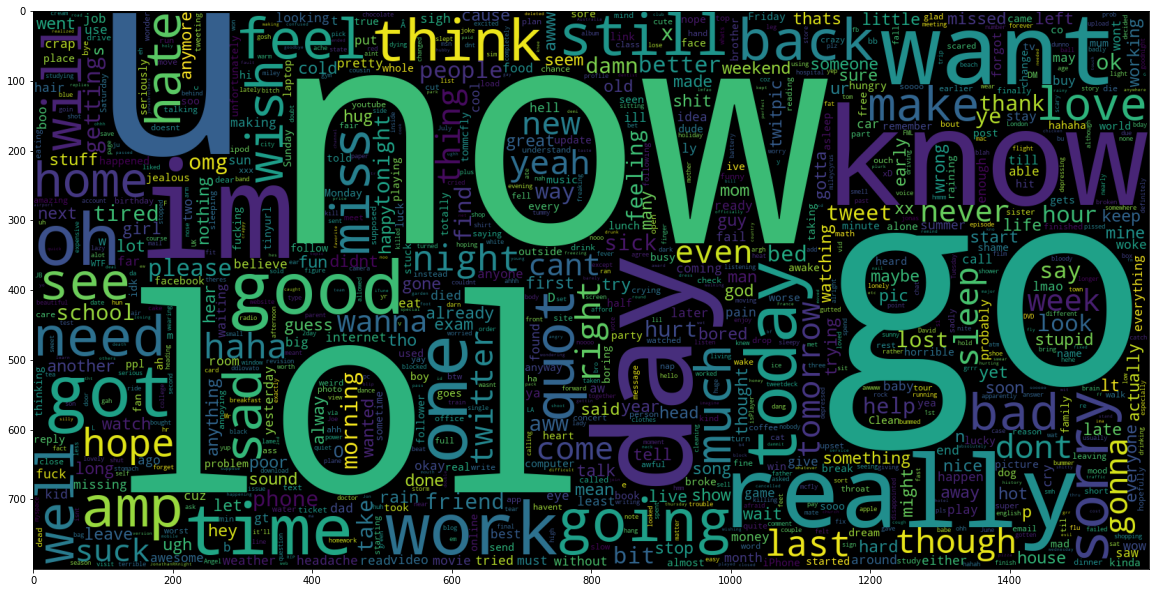

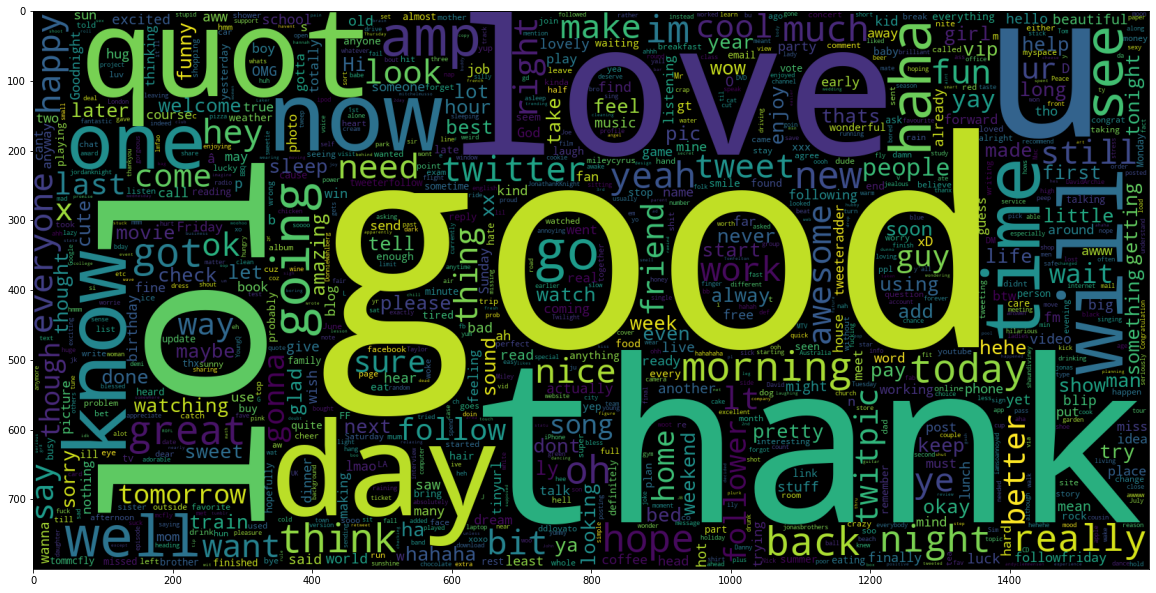

In [7]:
# Separating positive and negative tweets
data=df[['text','sentiment']]
data_pos = data[data['sentiment'] == '1']
data_neg = data[data['sentiment'] == '0']
dataset = pd.concat([data_pos, data_neg])

# Plot a word cloud for negative tweets
data_ne = data_neg['text']
plt.figure(figsize = (20,20))
wc_neg = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(" ".join(data_ne))
plt.imshow(wc_neg)

# Plot a word cloud for positive tweets
data_po = data_pos['text']
plt.figure(figsize = (20,20))
wc_pos = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(" ".join(data_po))
plt.imshow(wc_pos)

In [8]:
# Data preprocessing
dataset['text'] = dataset['text'].str.lower()


In [9]:
# Reduce repeated letter
def reduce_repeated_letters(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

dataset['text'] = dataset['text'].apply(reduce_repeated_letters)

In [462]:
# Expand contractions
dataset['text'] = dataset['text'].apply(lambda text: contractions.fix(text))

In [ ]:
# Remove Usenames
def remove_usernames(tweet):
    return re.sub('@[^\s]+', '', tweet)

dataset['text'] = dataset['text'].apply(remove_usernames)

In [280]:
# Remove StopWords

stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves', '&amp', '&quot']

STOPWORDSs = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDSs]) 

dataset['text'] = dataset['text'].apply(cleaning_stopwords)


In [ ]:
# Clean Punctuation
def cleaning_punctuations(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

dataset['text'] = dataset['text'].apply(cleaning_punctuations)


In [ ]:
# Cleaning and removing URL’s

def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))', ' ', data)

dataset['text'] = dataset['text'].apply(cleaning_URLs)

In [432]:
# Cleaning and Removing Numeric 
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

dataset['text'] = dataset['text'].apply(cleaning_numbers)

In [ ]:
# Applying stemming
stemmer = nltk.PorterStemmer()

def stemming_on_text(data):
    res = []
    for word in word_tokenize(data):
        res.append(stemmer.stem(word))
    return res

dataset['text'] = dataset['text'].apply(stemming_on_text)
dataset['text'] = dataset['text'].apply(cleaning_punctuations)

In [10]:
X=dataset.text
y=dataset.sentiment

# Splitting the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.15, random_state =26105111)

In [11]:
# Model pipeline
pipeline = Pipeline([   ("vect",TfidfVectorizer(ngram_range=(1,2), use_idf=True)),
                        ("chi", SelectKBest(chi2, k=25000)),
                        ("clf", LinearSVC(C=1.0, penalty="l1", max_iter=3000, dual=False))
                        # ("clf", MultinomialNB())
                    ])

In [12]:
# Fit the model
model = pipeline.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.78      0.75      0.77     14148
           1       0.83      0.85      0.84     19602

    accuracy                           0.81     33750
   macro avg       0.80      0.80      0.80     33750
weighted avg       0.81      0.81      0.81     33750



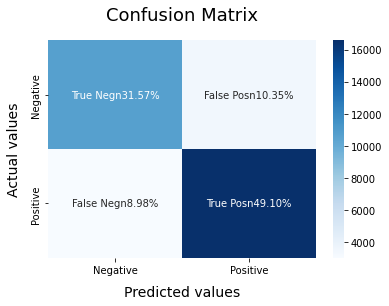

In [15]:
# Evaluate the model

def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    
    # Print the evaluation metrics for the dataset
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    
    
model_Evaluate(model)

In [ ]:
# Load the evaluation dataset
with open("D:\DSL\evaluation.csv" , encoding='utf8') as f:
  readers = list(csv.reader(f))
  col_names= readers.pop(0)
df_ev = pd.DataFrame(readers, columns=col_names)


In [ ]:
# Make predictions for the evaluation dataset
res = model.predict(df_ev['text'])
final_res = pd.DataFrame(res, columns=['Predicted'])
final_res.insert(0, 'Id', range(0, len(final_res)))

res = model.predict(df_ev['text'])
final_res = pd.DataFrame(res, columns=['Predicted'])
final_res.insert(0, 'Id', range(0, len(final_res)))
final_res.to_csv("D:/DSL/final/sample_submission.csv", index=None)